In [1]:
%matplotlib nbagg
#%load_ext line_profiler
#%load_ext memory_profiler

import jungfrau_utils as ju
import numpy as np
import json
import os, math
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

## Please add correct values of input parameters

In [2]:
roi1 = (7740, 7900, 220, 300) #signal 1
roi2 = (7740, 7900, 400, 480) #bkg 1

roi3 = (5080, 5220, 180, 280) #signal 2
roi4 = (5080, 5220, 300, 400) #bkg 2

Delay_mm = load_scan_readback('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_1.json')

Timezero = 215.50041   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !
Delay_fs = Delay_ps*1000

# glob.glob('/sf/alvra/data/p18938/res/Claudio/Febpy_XES_*')
Delay_mm


array([215.4237    , 215.43119333, 215.43868667, 215.44618   ,
       215.45367333, 215.46116667, 215.46866   , 215.47615333,
       215.48364667, 215.49114   , 215.49863333, 215.50612667,
       215.51362   , 215.52111333, 215.52860667, 215.5361    ,
       215.54359333, 215.55108667, 215.55858   , 215.56607333,
       215.57356667, 215.58106   , 215.58855333, 215.59604667,
       215.60354   , 215.61103333, 215.61852667, 215.62602   ,
       215.63351333, 215.64100667, 215.6485    ])

In [3]:
##### Loads .h5 files which contain the 2D maps generated in each time scan
loadfiles_all = []
files_title = '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_*'

for file in glob.glob('/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_*'):    
    loadfiles_all.append(file)

loadfiles_all = sorted(loadfiles_all, key = os.path.getmtime)
loadfiles = loadfiles_all[:-1]
loadfiles_all

['/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_1_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_2_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_3_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_4_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_5_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_6_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_7_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_8_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_9_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_10_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_11_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_12_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_tim

In [4]:
## reads data from loaded .h5 files and stores them as matrices 
###for pumped, unpumped and transient data for roi's

# Delay_mm = load_scan_readback('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_loop_1_2.json')

pumped_roi1 = 0
unpumped_roi1 = 0
transient_roi1 = 0
pumped_roi3 = 0
unpumped_roi3 = 0
transient_roi3 = 0

for fn in loadfiles:
    print (fn)
    with h5py.File(fn, "r") as file2open:
        RIXS_pumped_roi1 = file2open['RIXS_pumped_roi1'][:]
        RIXS_unpumped_roi1 = file2open['RIXS_unpumped_roi1'][:]
        RIXS_transient_roi1 = file2open['RIXS_transient_roi1'][:]
        RIXS_pumped_roi3 = file2open['RIXS_pumped_roi3'][:]
        RIXS_unpumped_roi3 = file2open['RIXS_unpumped_roi3'][:]
        RIXS_transient_roi3 = file2open['RIXS_transient_roi3'][:]
    
    pumped_roi1 += RIXS_pumped_roi1
    unpumped_roi1 += RIXS_unpumped_roi1
    transient_roi1 += RIXS_transient_roi1
    pumped_roi3 += RIXS_pumped_roi3
    unpumped_roi3 += RIXS_unpumped_roi3
    transient_roi3 += RIXS_transient_roi3

/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_1_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_2_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_3_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_4_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_5_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_6_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_7_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_8_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_9_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_10_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_11_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_12_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_13_export.h5
/sf/alvra/data/p18938

In [5]:
## define pixel axis from roi's given

pixel_axis_1 = np.array(np.linspace(roi1[0],roi1[1]-1,roi1[1]-roi1[0]))
pixel_axis_3 = np.array(np.linspace(roi3[0],roi3[1]-1,roi3[1]-roi3[0]))

<IPython.core.display.Javascript object>


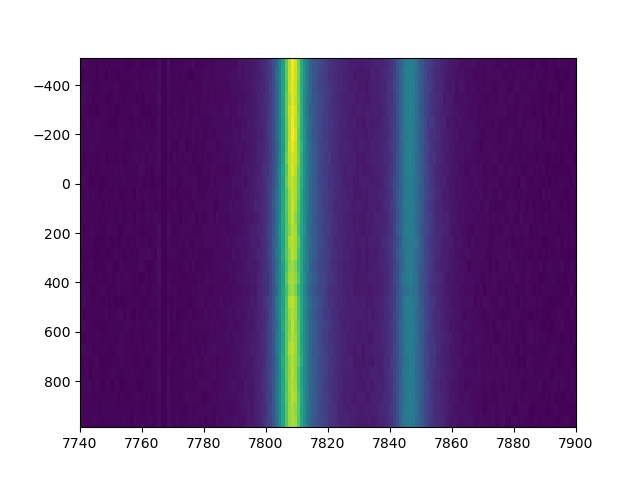

In [6]:
### plot 2D map of chosen data type

data_type = pumped_roi1
roi = roi1


plt.figure()
plt.imshow(data_type, aspect='auto', extent=[roi[0], roi[1], Delay_fs[-1], Delay_fs[0]])
plt.show()

# plt.figure()
# plt.plot(pixel_axis_1,data_type[1])

In [7]:
y_axis = pumped_roi1[14]

In [8]:
# plt.figure()
# plt.plot(pixel_axis_1,psv_function(pixel_axis_1,*fit))
# plt.plot(pixel_axis_1[:-60], y_axis[:-60])

In [9]:
pumped_roi1.shape

(31, 160)

In [10]:
def psv_function(x, A, a, mu, w, xc, z, zt):

    psv1 = (mu*(2/np.pi)*((2*w/(1+np.exp(-a*(x-xc))))/(4*(x-xc)**2+(2*w/(1+np.exp(-a*(x-xc))))**2)))
    
    psv2 = ((1-mu)*(np.sqrt(4*np.log(2))/(np.sqrt(np.pi)*((2*w/(1+np.exp(-a*(x-xc))))))))
    
    psv3 = (np.exp(-(4*np.log(2)/((2*w/(1+np.exp(-a*(x-xc)))**2)*(x-xc)**2))))
    
    psv4 = (x*z+zt)

    return (A*(psv1+(psv2*psv3)) + psv4)


## Next cells, fit voigt funtion to summed pumped data 

<IPython.core.display.Javascript object>


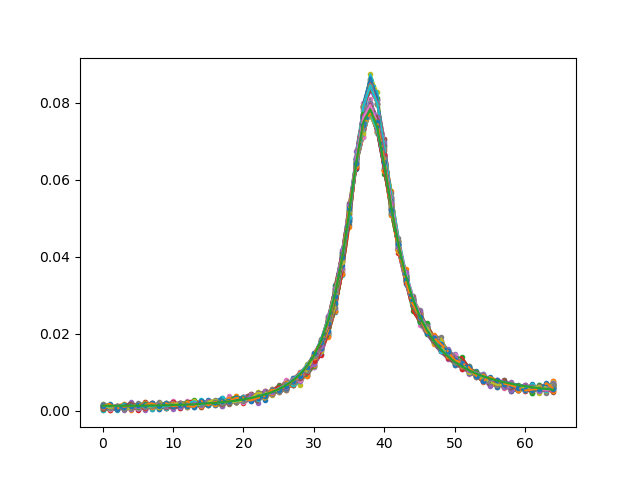

array([ 9.86821805e-01,  7.41149117e-02,  1.00023587e+00,  7.50307137e+00,
        7.80831368e+03,  1.95704639e-05, -1.50960109e-01])

In [11]:
#### choose limits for x axis around peak to be fitted:

limx1 = 30
limx2 = 95
pixel_axis = pixel_axis_1
data2fit = pumped_roi1


fit_params = []
fit_results = []
index = np.arange(0, data2fit.shape[0]-1,data2fit.shape[0])

### sum of unpumped data in selected region 

plt.figure()

#### we are looking at the roi row normalized by the sum of its intensity. Change y definition below
#### to have it normalized by the maximum value in the row

for i, y in enumerate(data2fit):
    x= pixel_axis[limx1:limx2]
    yu = unpumped_roi1[i]
#     y= y[limx1:limx2]/np.amax(y) 
    y= y[limx1:limx2]/np.sum(yu[limx1:limx2]) 
    plt.plot(y, '.-')
#     print(y.shape)
    plt.plot(y, '-.')
#     max_amp = np.amax(y)
    fit = p0 = [10,  8e-02,  1,  8,
        7809.5,  3.47e-01, -2.4e+03]
    fit, extras = curve_fit(psv_function,x,y, p0 = p0, maxfev = 25000)
    fit_params.append(fit)
    adelay = psv_function(x, *fit)
#     a.append(adelay)
    plt.plot(adelay)
#     fit_result = psv_function(pixel_axis[limx1:limx2],*fit)
    fit_results.append(adelay)
                          
                     

fitparams_matrix = np.array(fit_params)
fitresults_matrix = np.array(fit_results)
fitresults_matrix.shape
fitparams_matrix[1,:]

In [12]:
# # plt.figure()
# colors = plt.get_cmap('coolwarm', len(fwm_fit_results_evol))

# # residual_map = pumped_roi1-unpumped_roi1
# # residual_map_lim = residual_map[:,limx1:limx2]
# # # plt.imshow(residual_map_lim)
# # plt.stackplot(pixel_axis[limx1:limx2],residual_map_lim, color = colors(i))

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# x = pixel_axis[limx1:limx2]
# y = Delay_fs
# X,Y = np.meshgrid(x,y)
# Z = residual_map_lim

# ax.plot_surface(X, Y, Z, rstride=1, cstride=1000, cmap = 'viridis', shade=False, lw=.5)

# # ax.set_zlim(0, 5)
# # ax.set_xlim(-51, 51)
# # ax.set_zlabel("Intensity")
# ax.view_init(20,-120)
# plt.show()

## Next cell, fit fwhm to the width variation of the voigt as a funtion of time delay, for summed pumped data

<IPython.core.display.Javascript object>


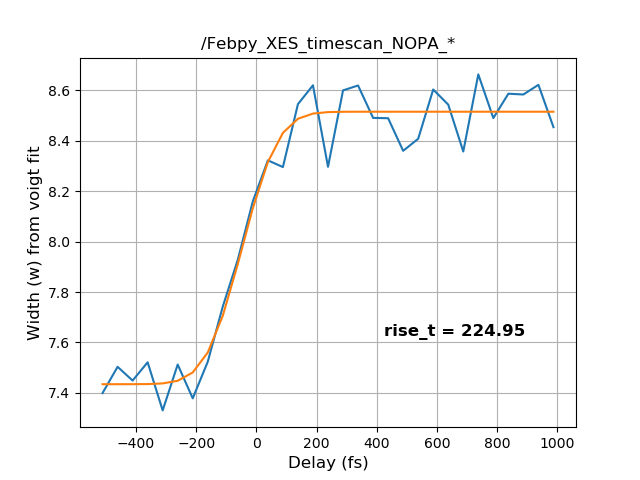

[  7.97482839  -0.54081805 -47.70901009 224.95451186]


Text(0.6, 0.3, 'rise_t = 224.95')

In [13]:
### looking at how the w paremeter of the void function changes with time delay

# p0 = [A, a, mu, w, xc, z, zt]
# p0 = [0, 1,  2, 3,  4, 5, 6]

plt.figure()
plt.plot(Delay_fs,fitparams_matrix[:,3])



fit_fwhm, extras = curve_fit(errfunc_fwhm, Delay_fs,fitparams_matrix[:,3], p0 = [40, -0.5, 40, 80])
print(fit_fwhm)
fwm = errfunc_fwhm(Delay_fs,*fit_fwhm)
fwm_ideal = errfunc_fwhm(Delay_fs, 8.6, -0.5, 50, 90)
# print(fwm)

plt.plot(Delay_fs,fwm)
plt.title(files_title[-26:])
plt.xlabel('Delay (fs)', fontsize = '12')
plt.ylabel('Width (w) from voigt fit',fontsize = '12')
plt.grid()
plt.figtext(0.6, 0.3, 'rise_t = ' + str(fit_fwhm[-1])[0:6], fontweight = 'bold', fontsize = '12')
# plt.plot(Delay_fs,fwm_ideal)
                             


<IPython.core.display.Javascript object>


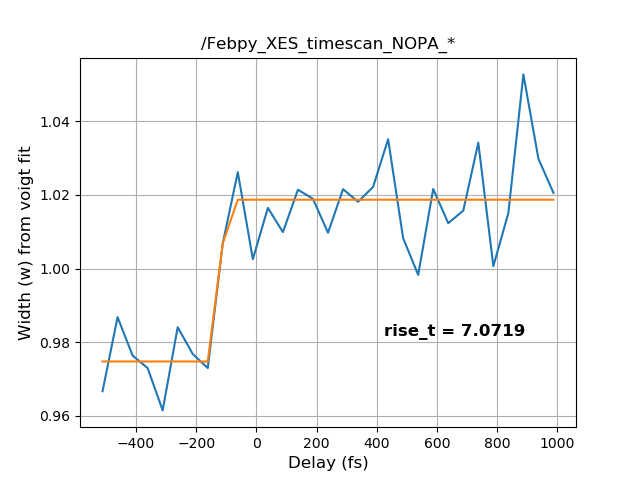

[ 9.96727556e-01 -2.19439683e-02 -1.13609089e+02  7.07194420e+00]


Text(0.6, 0.3, 'rise_t = 7.0719')

In [14]:
### looking at how the Amplitude A paremeter of the void function changes with time delay

# p0 = [A, a, mu, w, xc, z, zt]
# p0 = [0, 1,  2, 3,  4, 5, 6]

plt.figure()
plt.plot(Delay_fs, fitparams_matrix[:,0])

fit_fwhm, extras = curve_fit(errfunc_fwhm, Delay_fs,fitparams_matrix[:,0], p0 = [40, -0.5, 40, 80])
print(fit_fwhm)
fwm = errfunc_fwhm(Delay_fs,*fit_fwhm)
fwm_ideal = errfunc_fwhm(Delay_fs, 8.6, -0.5, 50, 90)
# print(fwm)

plt.plot(Delay_fs,fwm)
plt.title(files_title[-26:])
plt.xlabel('Delay (fs)', fontsize = '12')
plt.ylabel('Width (w) from voigt fit',fontsize = '12')
plt.grid()
plt.figtext(0.6, 0.3, 'rise_t = ' + str(fit_fwhm[-1])[0:6], fontweight = 'bold', fontsize = '12')
# plt.plot(Delay_fs,fwm_ideal)

In [15]:
# def errfunc_fwhm(x, a, b, c, d):
#     return a + b*erf((c-x)*2*np.sqrt(np.log(2))/(np.abs(d)))         #d is fwhm

## Next cell, reads roi pumped from each scan separately, and fits the voigt function for each time delay of each scan individually. Ouputs are lists of matrices

In [16]:
pumped_roi1_units = []


#### creates a file in which all the roi's are listed following the sequence of .h5 files read

for fn in loadfiles:
#     print (fn)
    with h5py.File(fn, "r") as file2open:
        RIXS_pumped_roi1 = file2open['RIXS_pumped_roi1'][:]
#         RIXS_unpumped_roi1 = file2open['RIXS_unpumped_roi1'][:]
#         RIXS_transient_roi1 = file2open['RIXS_transient_roi1'][:]
#         RIXS_pumped_roi3 = file2open['RIXS_pumped_roi3'][:]
#         RIXS_unpumped_roi3 = file2open['RIXS_unpumped_roi3'][:]
#         RIXS_transient_roi3 = file2open['RIXS_transient_roi3'][:]
    
    pumped_roi1_units.append(RIXS_pumped_roi1)
#     unpumped_roi1 += RIXS_unpumped_roi1
#     transient_roi1 += RIXS_transient_roi1
#     pumped_roi3 += RIXS_pumped_roi3
#     unpumped_roi3 += RIXS_unpumped_roi3
#     transient_roi3 += RIXS_transient_roi3




#### fitting all the rows from each of the .h5 files data and output fit parameters and fitresults in 
### large matrices of matrices
fitparams_matrices_units = []
fitresults_matrices_units = []

for unit in pumped_roi1_units:
        #### choose limits for x axis around peak to be fitted:

        limx1 = 30
        limx2 = 95
        pixel_axis = pixel_axis_1
        data2fit = unit


        fit_params = []
        fit_results = []
        index = np.arange(0, data2fit.shape[0]-1,data2fit.shape[0])

    #     plt.figure()

        for i, y in enumerate(data2fit):
            x= pixel_axis[limx1:limx2]
            yu = unpumped_roi1[i]
            y= y[limx1:limx2]/np.sum(yu[limx1:limx2])
        #     print(y.shape)
    #         plt.plot(y, '-.')
            fit = p0 = [1,  8e-02,  1,  8,7809.5,  3.47e-01, -2.4e+03]
            fit, extras = curve_fit(psv_function,x,y, p0 = p0, maxfev = 25000)
            fit_params.append(fit)
            adelay = psv_function(x, *fit)
        #     a.append(adelay)
    #         plt.plot(adelay)
        #     fit_result = psv_function(pixel_axis[limx1:limx2],*fit)
            fit_results.append(adelay)

        fitparams_matrix = np.array(fit_params)
        fitresults_matrix = np.array(fit_results)
        fitparams_matrices_units.append(fitparams_matrix)
        fitresults_matrices_units.append(fitresults_matrix)




<IPython.core.display.Javascript object>


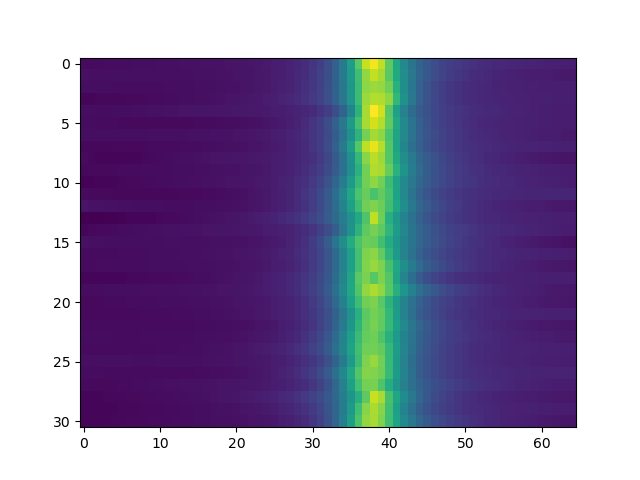

In [17]:
plt.figure()
plt.imshow(fitresults_matrices_units[15], aspect = 'auto')

## Next cell, fits the fwhm for the w parameter of the voigt, so we have the time_delay dependence of such parameter in each scan

#### plot 2 = fwhm width (parameter d) as a function of scan number

<IPython.core.display.Javascript object>


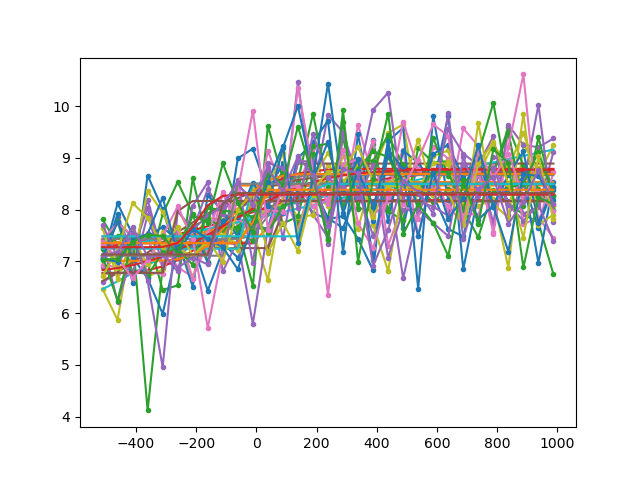

/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


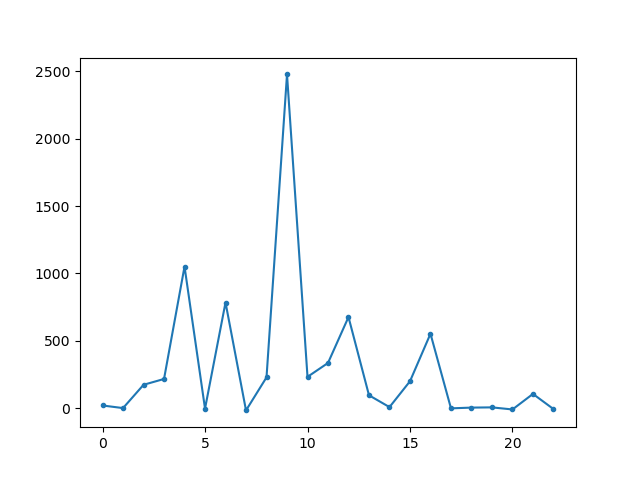

In [18]:
#### give the number of the voigt function parameter you want to look at:
#     p0 = [A, a, mu, w, xc, z, zt]
#     p0 = [0, 1,  2, 3,4, 5, 6]

j = 3
plt.figure()
counter = 0
fwidth = []
fwm_fitparams = []
fwm_fitresults = []

for file in loadfiles[:-5]:
    
    plt.plot(Delay_fs,fitparams_matrices_units[counter][:,j], '.-') ### plots the parameter j evolution in time
                                                                    ### for each and all of the .h5 files loaded
    fit_fwhm, extras = curve_fit(errfunc_fwhm, Delay_fs,fitparams_matrices_units[counter][:,j], p0 = [40, -0.5, 40, 80])
    
    fwidth.append(fit_fwhm[-1])  ### stores the value of the fitted parameter d from 
                                 ### the fit_fwm function for each .h5 file 
    
    fwm_fitparams.append(fit_fwhm)
    
    fwm = errfunc_fwhm(Delay_fs,*fit_fwhm)
    fwm_fitresults.append(fwm)   ### stores the calculated value for parameter j for each .h5 file 
                                 ### (calc from the fit parameters of the fit_fwm function) 
    
    plt.plot(Delay_fs,fwm)
    counter+=1
    
plt.figure()
plt.plot(fwidth, '.-')

fwm_fitparams = np.array(fwm_fitparams)
fwm_fitresults = np.array(fwm_fitresults)


### Below we see how parameter w (from voigt) changed for each scan individually. The average value of w is plotted as a red line for all values, and as a blue line after points that exceed the average alpha-1 times

##### choose alpha

<IPython.core.display.Javascript object>


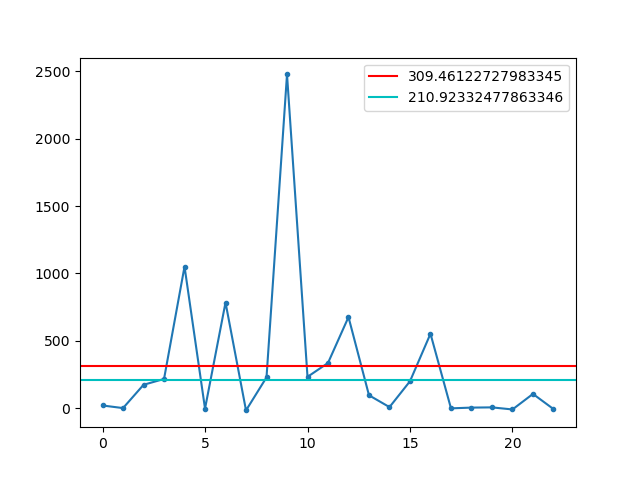

Runs index(array([9]),) deviate sigma times from average and were removed from the calculation of average 2


In [19]:
avg_weight = np.ones(len(fwidth))
avg_width1 = np.average(fwidth)


alpha = 4

plt.figure()
plt.plot(fwidth, '.-')
plt.axhline(avg_width1, color = 'r', label = str(avg_width1))


for counter, i in enumerate(fwidth):
    if i > alpha*avg_width1:
        avg_weight[counter] = 0
        
            
avg_tmp = np.average(fwidth, weights = avg_weight)
plt.axhline(avg_tmp, color = 'c', label = str(avg_tmp))
plt.legend()

print('Runs index' + str(np.where(np.array(avg_weight)== 0)) + ' deviate sigma times from average and were removed from the calculation of average 2' )

## Does the fit of the average improve when we remove above outliers????

In [70]:
## reads data from loaded .h5 files and stores them as matrices 
###for pumped, unpumped and transient data for roi's

# Delay_mm = load_scan_readback('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_loop_1_2.json')

####################################

remove_index = [9]


#####################################
pumped_roi1_clean = 0
unpumped_roi1_clean = 0
loadfiles_clean = []

for i, file in enumerate(loadfiles):
    if i not in remove_index:
        loadfiles_clean.append(file)


for fn in loadfiles_clean:
    print (fn)
    with h5py.File(fn, "r") as file2open:
        RIXS_pumped_roi1_clean = file2open['RIXS_pumped_roi1'][:]
        RIXS_unpumped_roi1_clean = file2open['RIXS_unpumped_roi1'][:]
#         RIXS_transient_roi1 = file2open['RIXS_transient_roi1'][:]
#         RIXS_pumped_roi3 = file2open['RIXS_pumped_roi3'][:]
#         RIXS_unpumped_roi3 = file2open['RIXS_unpumped_roi3'][:]
#         RIXS_transient_roi3 = file2open['RIXS_transient_roi3'][:]

    pumped_roi1_clean += RIXS_pumped_roi1_clean
    unpumped_roi1_clean += RIXS_unpumped_roi1_clean
#     transient_roi1 += RIXS_transient_roi1
#     pumped_roi3 += RIXS_pumped_roi3
#     unpumped_roi3 += RIXS_unpumped_roi3
#     transient_roi3 += RIXS_transient_roi3


/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_1_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_2_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_3_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_4_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_5_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_6_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_7_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_8_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_9_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_11_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_12_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_13_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_14_export.h5
/sf/alvra/data/p18938

<IPython.core.display.Javascript object>


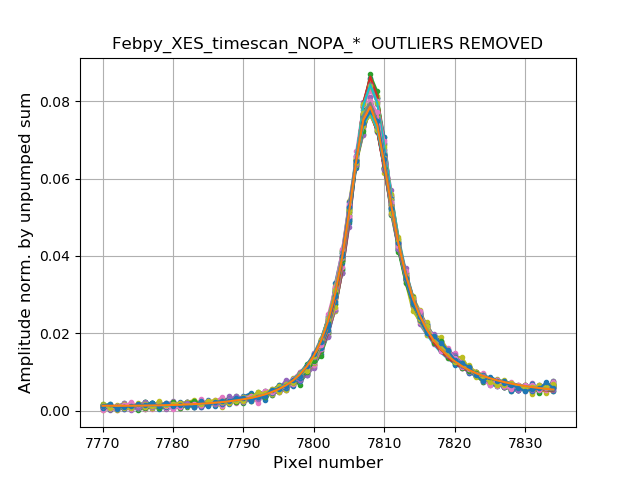

array([ 9.88357890e-01,  7.30965247e-02,  1.00006663e+00,  7.52024936e+00,
        7.80832470e+03,  2.09520126e-05, -1.61825773e-01])

In [71]:
#### choose limits for x axis around peak to be fitted:

limx1 = 30
limx2 = 95
pixel_axis = pixel_axis_1
data2fit = pumped_roi1_clean


fit_params = []
fit_results = []
index = np.arange(0, data2fit.shape[0]-1,data2fit.shape[0])

### sum of unpumped data in selected region 

plt.figure()

#### we are looking at the roi row normalized by the sum of its intensity. Change y definition below
#### to have it normalized by the maximum value in the row

for i, y in enumerate(data2fit):
    x= pixel_axis[limx1:limx2]
    yu = unpumped_roi1_clean[i]
#     y= y[limx1:limx2]/np.amax(y) 
    y= y[limx1:limx2]/np.sum(yu[limx1:limx2]) 
    plt.plot(x, y, '.-')
#     print(y.shape)
#     max_amp = np.amax(y)
    fit = p0 = [10,  8e-02,  1,  8,
        7809.5,  3.47e-01, -2.4e+03]
    fit, extras = curve_fit(psv_function,x,y, p0 = p0, maxfev = 25000)
    fit_params.append(fit)
    adelay = psv_function(x, *fit)
#     a.append(adelay)
    plt.plot(x, adelay)
#     fit_result = psv_function(pixel_axis[limx1:limx2],*fit)
    fit_results.append(adelay)
                          
                          
plt.title(files_title[-25:] + '  OUTLIERS REMOVED')
plt.xlabel('Pixel number', fontsize = '12')
plt.ylabel('Amplitude norm. by unpumped sum',fontsize = '12')
plt.grid()                     

fitparams_matrix_clean = np.array(fit_params)
fitresults_matrix_clean = np.array(fit_results)
fitresults_matrix_clean.shape
fitparams_matrix_clean[1,:]

<IPython.core.display.Javascript object>


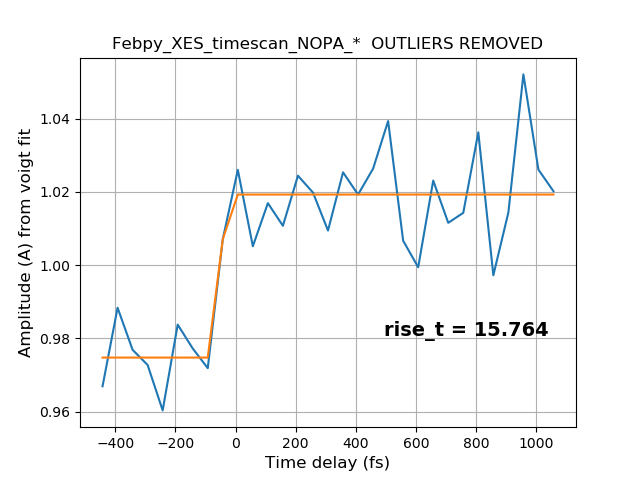

[ 9.97010404e-01 -2.22599415e-02 -4.63847270e+01  1.57645772e+01]


In [72]:
### looking at how the Amplitude A paremeter of the void function changes with time delay

# p0 = [A, a, mu, w, xc, z, zt]
# p0 = [0, 1,  2, 3,  4, 5, 6]

fwm_clean = 0

plt.figure()
plt.plot(Delay_fs, fitparams_matrix_clean[:,0])

fit_fwhm, extras = curve_fit(errfunc_fwhm, Delay_fs,fitparams_matrix_clean[:,0], p0 = [1, -0.5, 40, 80])
print(fit_fwhm)
fwm_clean = errfunc_fwhm(Delay_fs,*fit_fwhm)
fwm_ideal = errfunc_fwhm(Delay_fs, 8.6, -0.5, 50, 90)
# print(fwm)
plt.title(files_title[-25:] + '  OUTLIERS REMOVED')
plt.xlabel('Time delay (fs)', fontsize = '12')
plt.ylabel('Amplitude (A) from voigt fit',fontsize = '12')
plt.figtext(0.6, 0.3, 'rise_t = ' + str(fit_fwhm[-1])[0:6], fontweight = 'bold', fontsize = '14')
plt.grid()

plt.plot(Delay_fs,fwm_clean)
# plt.plot(Delay_fs,fwm_ideal)

<IPython.core.display.Javascript object>


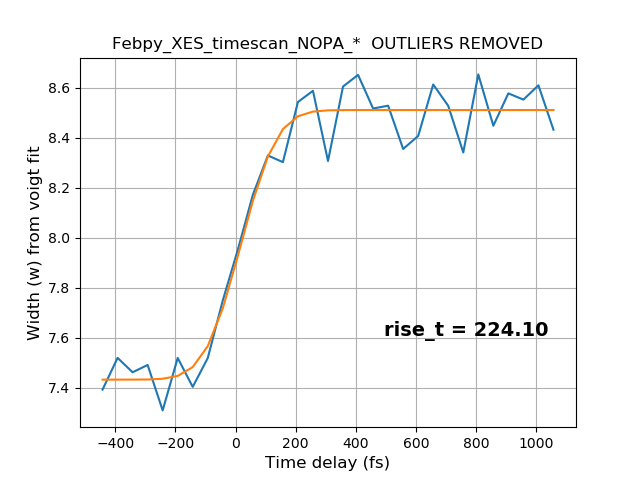

[  7.9722746   -0.53909081  17.53019092 224.1029928 ]


In [73]:
### looking at how the w paremeter of the void function changes with time delay

# p0 = [A, a, mu, w, xc, z, zt]
# p0 = [0, 1,  2, 3,  4, 5, 6]

plt.figure()
plt.plot(Delay_fs,fitparams_matrix_clean[:,3])



fit_fwhm, extras = curve_fit(errfunc_fwhm, Delay_fs,fitparams_matrix_clean[:,3], p0 = [40, -0.5, 40, 80])
print(fit_fwhm)
fwm = errfunc_fwhm(Delay_fs,*fit_fwhm)
fwm_ideal = errfunc_fwhm(Delay_fs, 8.6, -0.5, 50, 90)
# print(fwm)
plt.title(files_title[-25:] + '  OUTLIERS REMOVED')
plt.xlabel('Time delay (fs)', fontsize = '12')
plt.ylabel('Width (w) from voigt fit',fontsize = '12')
plt.figtext(0.6, 0.3, 'rise_t = ' + str(fit_fwhm[-1])[0:6], fontweight = 'bold', fontsize = '14')
plt.grid()

plt.plot(Delay_fs,fwm)
# plt.plot(Delay_fs,fwm_ideal)


## The next cell creates lists with the roi's, following:
## roi[i] = sum of the [0:i+1] scan

In [166]:
#### give the number of the voigt function parameter you want to look at:
#     p0 = [A, a, mu, w, xc, z, zt]
#     p0 = [0, 1,  2, 3,4, 5, 6]

j = 3
idx = np.linspace(0, len(loadfiles)-1,len(loadfiles))

# plt.figure()

fwidth = []
fwm_fitparams = []
fwm_fitresults = []
cumulative_fwm_params = []
pumped_roi1_tmp = 0
pumped_roi1_evol = []



for i in idx:
    pumped_roi1_tmp = 0
    
    for file in loadfiles[0:int(i)+1]:
#         print(file)
        with h5py.File(file, "r") as file2open:
            RIXS_pumped_roi1_tmp = file2open['RIXS_pumped_roi1'][:]
#         RIXS_unpumped_roi1_tmp = file2open['RIXS_unpumped_roi1'][:]
#         RIXS_transient_roi1_tmp = file2open['RIXS_transient_roi1'][:]
#         RIXS_pumped_roi3_tmp = file2open['RIXS_pumped_roi3'][:]
#         RIXS_unpumped_roi3_tmp = file2open['RIXS_unpumped_roi3'][:]
#         RIXS_transient_roi3_tmp = file2open['RIXS_transient_roi3'][:]   
            pumped_roi1_tmp += RIXS_pumped_roi1_tmp
#     unpumped_roi1_tmp += RIXS_unpumped_roi1_tmp
#     transient_roi1_tmp += RIXS_transient_roi1_tmp
#     pumped_roi3_tmp += RIXS_pumped_roi3_tmp
#     unpumped_roi3_tmp += RIXS_unpumped_roi3_tmp
#     transient_roi3_tmp += RIXS_transient_roi3_tmp
    pumped_roi1_evol.append(pumped_roi1_tmp)

## voigt fit to each of the roi[i] - fit_results and fit_param evolution in the matrices with shapes: 

## (ns x td x pix) and (ns x td x voigtparam) respectively

### ns = number of scans, td = number of time delays scaned, pix = pixels considered, voigtparam = 7

In [171]:
#     limx1 = 30
#     limx2 = 95
#     pixel_axis = pixel_axis_1
#     # data2fit_tmp = pumped_roi1_tmp
#     fit_params = []
#     fit_results = []
#     index = np.arange(0, data2fit_tmp.shape[0]-1,data2fit_tmp.shape[0])
limx1 = 30
limx2 = 95

fit_results_evol = []
fit_params_evol = []

for roi in pumped_roi1_evol:
    pixel_axis = pixel_axis_1
    # data2fit_tmp = pumped_roi1_tmp
    fit_params = []
    fit_results = []
    
    data2fit = roi
    for i, y in enumerate(data2fit):
        x= pixel_axis[limx1:limx2]
        yu = unpumped_roi1[i]
        y= y[limx1:limx2]/np.sum(yu[limx1:limx2])
        #     print(y.shape)
        plt.plot(y, '-.')
        fit = p0 = [1,  8e-02,  1,  8,
            7809.5,  3.47e-01, -2.4e+03]
        fit, extras = curve_fit(psv_function,x,y, p0 = p0, maxfev = 25000)
        fit_params.append(fit)
        adelay = psv_function(x, *fit)
        #     a.append(adelay)
#         plt.plot(adelay)
        #     fit_result = psv_function(pixel_axis[limx1:limx2],*fit)
        fit_results.append(adelay)
    
    fit_results_evol.append(fit_results)
    fit_params_evol.append(fit_params)

fitparams_matrix_evol = np.array(fit_params_evol)
fitresults_matrix_evol = np.array(fit_results_evol)
    

In [172]:
fitresults_matrix_evol.shape, fitparams_matrix_evol.shape

((28, 31, 65), (28, 31, 7))

## Next cell fits the fwhm for each roi[i] and stores the result in fwm_fit_params_evol

In [173]:
#     p0 = [A, a, mu, w, xc, z, zt]
#     p0 = [0, 1,  2, 3,4, 5, 6]

j=3

fwm_fit_params_evol = []
fwm_fit_results_evol = []

for counter, roi in enumerate(fitparams_matrix_evol):
    fit_fwhm_tmp, extras = curve_fit(errfunc_fwhm, Delay_fs,fitparams_matrix_evol[counter][:,j], p0 = [40, -0.5, 40, 80])
#     print(fit_fwhm_tmp)
    fwm_fit_results = errfunc_fwhm(Delay_fs,*fit_fwhm_tmp)
    
    fwm_fit_params_evol.append(fit_fwhm_tmp)
    fwm_fit_results_evol.append(fwm_fit_results)

fwm_fit_params_evol = np.array(fwm_fit_params_evol)
fwm_fit_results_evol = np.array(fwm_fit_results_evol)

<IPython.core.display.Javascript object>


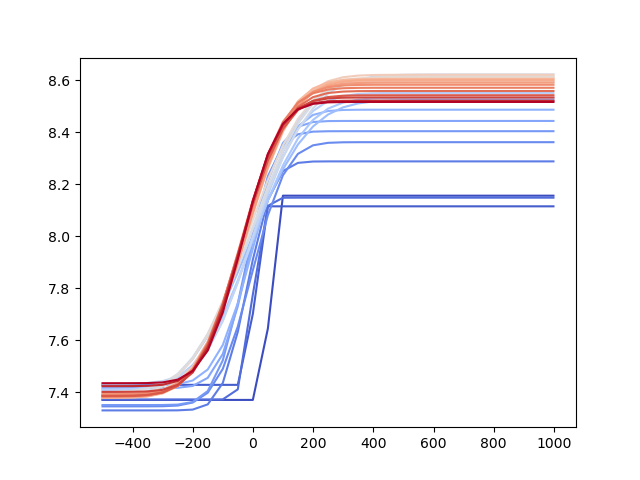

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [174]:
a = fwm_fit_results_evol.shape
fig = plt.figure()
ax = fig.add_subplot(111)
colors = plt.get_cmap('coolwarm', len(fwm_fit_results_evol))
print(colors)

for i, scan_cumul in enumerate(fwm_fit_results_evol):
    y = Delay_fs
    x = scan_cumul
    ax.plot(y, x, color = colors(i))

plt.tight_layout

## evolution of width (parameter d) from fwhm as more scans are added

<IPython.core.display.Javascript object>


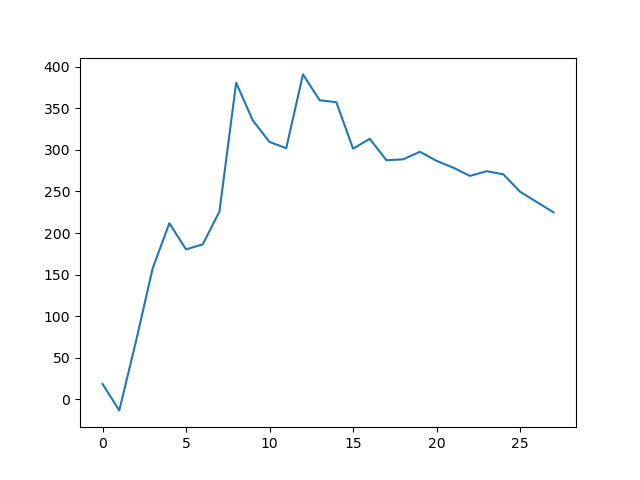

In [175]:
plt.figure()
plt.plot(np.array(fwm_fit_params_evol)[:,3])


## Next cell, we find the standard deviation of data from the unpumped data
## Look for fluctuations pump-independent

In [176]:
unpumped_roi1.shape

(31, 160)

### below is the summed roi -  using all scans in loadfiles

<IPython.core.display.Javascript object>


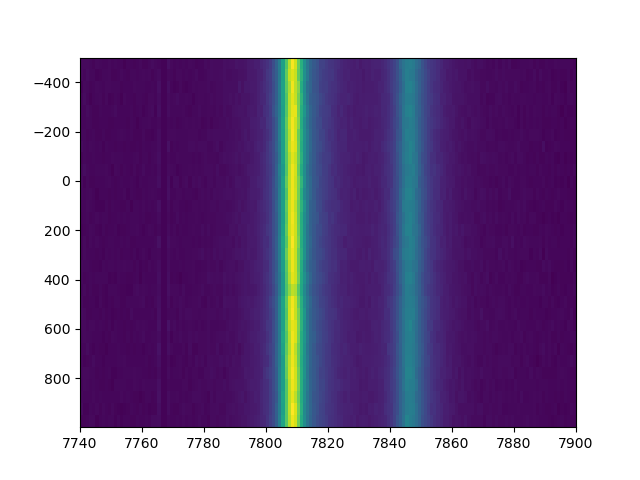

In [177]:
### plot 2D map of chosen data type

data_type = unpumped_roi1
roi = roi1

plt.figure()
plt.imshow(data_type, aspect='auto', extent=[roi[0], roi[1], Delay_fs[-1], Delay_fs[0]])
plt.show()

# plt.figure()
# plt.plot(pixel_axis_1,data_type[1])

<IPython.core.display.Javascript object>


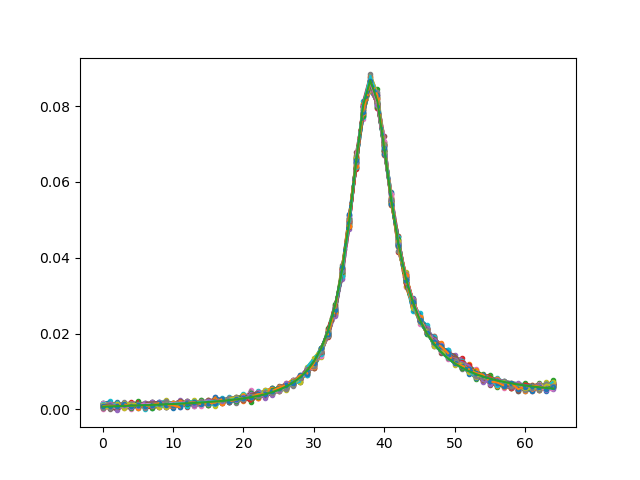

In [178]:
#### choose limits for x axis around peak to be fitted:

limx1 = 30
limx2 = 95
pixel_axis = pixel_axis_1
data2fit = unpumped_roi1


fit_params = []
fit_results = []
index = np.arange(0, data2fit.shape[0]-1,data2fit.shape[0])

plt.figure()

#### we are looking at the roi row normalized by the sum of its intensity. Change y definition below
#### to have it normalized by the maximum value in the row

for y in data2fit:
    x= pixel_axis[limx1:limx2]
#     y= y[limx1:limx2]/np.amax(y) 
    y= y[limx1:limx2]/np.sum(y[limx1:limx2]) 
    plt.plot(y, '.-')
#     print(y.shape)
    plt.plot(y, '-.')
#     max_amp = np.amax(y)
    fit = p0 = [10,  8e-02,  1,  8,
        7809.5,  3.47e-01, -2.4e+03]
    fit, extras = curve_fit(psv_function,x,y, p0 = p0, maxfev = 25000)
    fit_params.append(fit)
    adelay = psv_function(x, *fit)
#     a.append(adelay)
    plt.plot(adelay)
#     fit_result = psv_function(pixel_axis[limx1:limx2],*fit)
    fit_results.append(adelay)
                          
                     

fitparams_matrix_unp = np.array(fit_params)
fitresults_matrix_unp = np.array(fit_results)


In [179]:
#### use these parameters to fit next cell
fit_avg = np.average(fitparams_matrix_unp, axis = 0)
fit_avg

array([ 9.78963004e-01,  7.94249740e-02,  1.00052539e+00,  7.44895869e+00,
        7.80831598e+03,  1.52753422e-05, -1.17152313e-01])

In [180]:
# REFERENCE CURVE

reference_curve = adelay = psv_function(pixel_axis_1[limx1:limx2], *fit_avg)

# plt.figure()
# plt.plot(pixel_axis_1[limx1:limx2], reference_curve, '.-')
# len(reference_curve)

### now, next cell reads and registers each umpumped roi from each scan and calculates 
### the residual  = (value - average)^2

In [189]:
unpumped_roi1_units = []


#### creates a file in which all the roi's are listed following the sequence of .h5 files read

for fn in loadfiles:
#     print (fn)
    with h5py.File(fn, "r") as file2open:
        RIXS_unpumped_roi1 = file2open['RIXS_unpumped_roi1'][:]
    unpumped_roi1_units.append(RIXS_unpumped_roi1)

residuals_all = []

for unit in unpumped_roi1_units:

    #     plt.figure()
    residuals = []
    for y in unit:
        ynorm = y[limx1:limx2]/np.sum(y[limx1:limx2])
        residual = (reference_curve - ynorm)**2
        residuals.append(residual)
        
    residuals_all.append(residuals)

## Calculating the standard deviation in unpumped data

In [190]:
## standard deviation calculation

np.array(residuals_all).shape
# residuals_all[6]

(28, 31, 65)

<IPython.core.display.Javascript object>


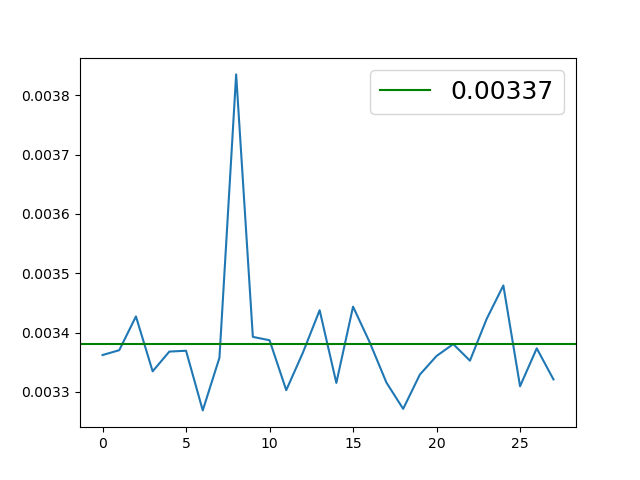

In [195]:
stand_dev_units = []

for unit in residuals_all:
    stand_dev = np.sqrt(np.average(np.array(unit)))
    stand_dev_units.append(stand_dev)

sigma_umpumped = np.average(stand_dev_units)

plt.figure()
plt.plot(stand_dev_units)
plt.axhline(np.average(stand_dev_units), color = 'g', label = str(sigma_umpumped)[0:7])
plt.legend(fontsize = 18)

In [192]:
## STANDARD DEVIATION IN UMPEPED DATA = 
sigma_unpumped = np.average(stand_dev_units)
sigma_unpumped

0.003379838933346592

In [ ]:
plt.figure()
colors = plt.get_cmap('coolwarm', len(fwm_fit_results_evol))
for i, y in enumerate(data2fit):
    yu = unpumped_roi1[i]
    plt.plot(y[limx1:limx2]-yu[limx1:limx2], color = colors(i))

## Calculating deviations from pumped data with respect to ideal curve from unpumped data

In [193]:
residuals_pumped_all = []

for i, unit in enumerate(pumped_roi1_units):
    unp_roi = unpumped_roi1_units[i]
    #     plt.figure()
    residuals = []
    for j, y in enumerate(unit):
        yu = unp_roi[j]
        ynorm = y[limx1:limx2]/np.sum(yu[limx1:limx2])
        residual_absolute = np.absolute(reference_curve - ynorm)
        residual_squared = (reference_curve - ynorm)**2
        residuals.append(residual_absolute)
        
    residuals_pumped_all.append(residuals)

<IPython.core.display.Javascript object>


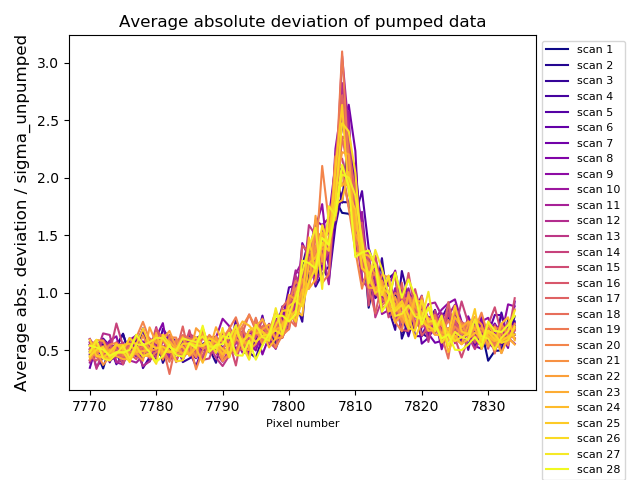

In [194]:
### average of residuals per run
### plot shows absolute residuals average for all time delays for each run
### (average is done on the x axis direction of the time x pixel map matrix)

plt.figure()
colors = plt.get_cmap('plasma', len(residuals_pumped_all))

avrg_resi_run = []

for i, res in enumerate(residuals_pumped_all):
    avrg_run = np.average(res, axis = 0)
    plt.plot(pixel_axis[limx1:limx2],avrg_run/sigma_umpumped, color = colors(i), label = 'scan ' + str(i+1))
    plt.xlabel('Pixel number', fontsize = 8)
    plt.ylabel('Average abs. deviation / sigma_unpumped', fontsize = 12)
    
    avrg_resi_run.append(avrg_run)

plt.legend(loc = 'best', bbox_to_anchor = (1,1), fontsize = 8)
plt.title('Average absolute deviation of pumped data')
plt.tight_layout()

# plt.figure()
# # plt.imshow(residuals_pumped_all[8])
# plt.plot(np.array(residuals_pumped_all[8]))

## Average deviation 

## Calculate the deviation from ideal curves for pumped data
### Each time delay has its ideal curve calculated from average map
